In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import ntpath

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
import cv2

import imgaug as ia
import imgaug.augmenters as iaa

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


## Lectura del fichero CSV
Vamos a suponer que no se ha cambiado el nombre del fichero csv generado en el simulador, y que se encuentra en la misma carpeta que este Notebook.

In [2]:
def lee_csv():
    #Lectura en crudo del fichero CSV generado, añadiendo los labels a cada columna
    columnas = ['centro', 'izquierda', 'derecha', 'angulo', 'acelerador', 'freno', 'velocidad']
    datos = pd.read_csv('driving_log.csv', names = columnas)

    return datos

## Renombre de la ruta de las imágenes
Se elimina la ruta absoluta de las imágenes, de esta forma el dataset puede ser usado en diferentes máquinas y/o en diferentes carpetas.

In [3]:
def renombra_imagenes(datos):
    #Modificación de las 3 primeras columnas, correspondiente a la ruta de las imágenes
    datos['centro'] = datos['centro'].apply(get_tail)
    datos['izquierda'] = datos['izquierda'].apply(get_tail)
    datos['derecha'] = datos['derecha'].apply(get_tail)
    
    return datos

#Función para obtener la 'hoja' del árbol perteneciente a la ruta absoluta de la imagen, que corresponde con su nombre
def get_tail(path):
    head, tail = ntpath.split(path) #Separando por "/", tail es el último elemento, y head todo lo anterior
    
    return tail

## Funciones de generación y dibujado del histograma

In [4]:
def genera_histograma(datos, num_bins):
    #Generación del histograma (sus variables serán usadas en la celda siguiente para procesar los elementos sobrantes)
    hist, bins = np.histogram(datos['angulo'], num_bins)
    return hist, bins

def dibuja_histograma(datos, num_bins, max_muestras_por_bin=0):
    #Dibujado del histograma
    plt.hist(datos['angulo'], num_bins)

    plt.xlabel('Ángulo')
    plt.ylabel('Frecuencia')
    plt.title("Distribución de los ángulos") 

    if max_muestras_por_bin != 0:
        #Línea representando max_muestras_por_bin sobre el histograma
        plt.plot((np.min(datos['angulo']), np.max(datos['angulo'])), (max_muestras_por_bin, max_muestras_por_bin))

    plt.show()

## Balanceo del dataset

In [5]:
#-------------BALANCEO DEL DATASET------------------------
def balancea_dataset(datos, num_bins, bins, max_muestras_por_bin):
    datos_preprocesados = datos.copy() #Copia del dataset original
    elementos_a_eliminar = []

    #Recorrido de cada bin
    for i in range(num_bins):
      lista = []
    #Recorrido de cada elemento del dataset: si el ángulo pertenece al bin que estamos recorriendo, lo 
    #metemos en la lista
      for j in range(len(datos['angulo'])):
        if datos['angulo'][j] >= bins[i] and datos['angulo'][j] <= bins[i+1]:
          lista.append(j)

    #Mezclamos los elementos que pertenecen al bin
      lista = shuffle(lista)
      #Nos quedamos con las "sobras" basado en el umbral que hayamos decidido (max_muestras_por_bin), para posteriormente
      #añadirlo a elementos_a_eliminar y utilizarla como lista con los elementos a eliminar en el dataset
      lista = lista[max_muestras_por_bin:]
      elementos_a_eliminar.extend(lista)

    #Eliminamos dichos datos del dataset
    datos_preprocesados.drop(datos_preprocesados.index[elementos_a_eliminar], inplace=True)
    
    return datos_preprocesados

## Función para devolver solo las imágenes y los ángulos del dataset

Ahora se seleccionan todas las imágenes del dataset, no solo las de la cámara central

In [6]:
#Obtención de las imágenes y sus ángulos del dataset
def get_imgs_y_angulos(datos):
    imagenes = []
    angulos = []
    for i in range(len(datos)):
        elemento = datos.iloc[i]
        
        angulo = elemento[3]
        
        #Imagen central
        imagen_centro = elemento[0]
        imagenes.append(os.path.join('IMG/', imagen_centro))
        angulos.append(angulo)
        
        #Imagen izquierda
        imagen_izquierda = elemento[1]
        imagenes.append(os.path.join('IMG/', imagen_izquierda))
        angulos.append(angulo + 0.2)
        
        #Imagen derecha
        imagen_derecha = elemento[2]
        imagenes.append(os.path.join('IMG/', imagen_derecha))
        angulos.append(angulo - 0.2)
        
    imagenes = np.asarray(imagenes)
    angulos = np.asarray(angulos)
    
    return imagenes, angulos

## División del dataset en conjuntos de entrenamiento y prueba

In [7]:
#División del dataset en conjuntos de entrenamiento y prueba
def divide_dataset(imagenes, angulos):
    x_entrenamiento, x_test, y_entrenamiento, y_test = train_test_split(imagenes, angulos, train_size=0.8)
    
    return x_entrenamiento, x_test, y_entrenamiento, y_test

## Funciones para la transformación de imágenes

In [8]:
#-----CONJUNTO DE FUNCIONES PARA EL PREPROCESAMIENTO DE IMÁGENES----
def recorte(img):
    img = img[70:135,:,:] 
    return img

def RGBaYUV(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) 
    return img

def RGBaGRAY(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

def redimensionar_imagen(img, x, y):
    img = cv2.resize(img, (x, y))
    return img

def normalizar_imagen(img):
    img = img/255
    return img

## Preprocesamiento de imágenes necesario para cada arquitectura neuronal

In [9]:
#Función de preprocesamiento de imágenes para el modelo de LeNet-5
def img_preproceso_lenet5(img):
    
    img = recorte(img)
    img = RGBaGRAY(img)
    img = redimensionar_imagen(img, 32, 32)
    img = img[:, :, np.newaxis]
    img = normalizar_imagen(img)
    return img

#Función de preprocesamiento de imágenes para el modelo de NVIDIA
def img_preproceso_nvidia(img):
    
    img = recorte(img)
    img = RGBaYUV(img)
    img = redimensionar_imagen(img, 200, 66)
    img = normalizar_imagen(img)
    return img

## Transformaciones de _data augmentation_

In [10]:
def iluminacion(img):
    iluminacion = iaa.Multiply((0.2, 1.3))
    img = iluminacion.augment_image(img)
    
    return img

def zooming(img):
    zooming = iaa.Affine(scale={"x": (1.0, 1.4), "y": (1.0, 1.4)})
    img = zooming.augment_image(img)
    
    return img

def desplazamiento(img):
    desplazamiento = iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
    img = desplazamiento.augment_image(img)
    
    return img

def volteo(img, angulo):
    volteo = iaa.Fliplr(1.0)
    img = volteo.augment_image(img)
    angulo = -angulo
    
    return img, angulo

## Aumento aleatorio de las imágenes con las transformaciones anteriores

In [11]:
def aumento_aleatorio(img, angulo):
    img = mpimg.imread(img)
    
    if np.random.random_sample() < 0.5:
        img = iluminacion(img)
        
    if np.random.random_sample() < 0.5:
        img = zooming(img)
        
    if np.random.random_sample() < 0.5:
        img = desplazamiento(img)
        
    if np.random.random_sample() < 0.5:
        img, angulo = volteo(img, angulo)
    
    return img, angulo

## Definición de los dos modelos neuronales

In [12]:
def crea_modelo_lenet5():
    modelo = Sequential()

    modelo.add(Conv2D(6, (5, 5), activation='elu', input_shape=(32, 32, 1)))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(16, (5, 5), activation='elu'))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))

    modelo.add(Conv2D(120, (5, 5), activation='elu'))
    
    modelo.add(Flatten())

    modelo.add(Dense(84, activation='elu'))

    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo


def crea_modelo_nvidia():
    modelo = Sequential()
    
    modelo.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    modelo.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    modelo.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    modelo.add(Conv2D(64, (3, 3), activation='elu'))
    modelo.add(Conv2D(64, (3, 3), activation='elu'))
    
    modelo.add(Flatten())
    
    modelo.add(Dense(100, activation='elu'))
    modelo.add(Dense(50, activation='elu'))
    modelo.add(Dense(10, activation='elu'))
    modelo.add(Dense(1))
    
    optimizador = Adam(lr=1e-3)
    modelo.compile(loss='mse', optimizer=optimizador)
    
    return modelo

## _Batch generator_

In [13]:
#red acepta: 'nvidia' o 'lenet5'
def batch_generator(imgs, angulos, batch_size, modo, red):
    
    while True:
        batch_imgs = []
        batch_angulos = []
        
        for i in range(batch_size):
            #Número aleatorio que actuará de índice para el conjunto de imágenes
            num_aleatorio = random.randint(0, len(imgs)-1)
            
            if modo == 'entrenamiento':
                img, angulo = aumento_aleatorio(imgs[num_aleatorio], angulos[num_aleatorio])
                
            else:
                img = mpimg.imread(imgs[num_aleatorio])
                angulo = angulos[num_aleatorio]
                
            if red == 'nvidia':
                img = img_preproceso_nvidia(img)
            elif red == 'lenet5':
                img = img_preproceso_lenet5(img)
            else:
                raise ValueError('No se ha seleccionado ninguna de las dos redes neuronales!')
                
            batch_imgs.append(img) 
            batch_angulos.append(angulo)
            
        yield(np.asarray(batch_imgs), np.asarray(batch_angulos))

## Entrenamiento del modelo

Se usará fit_generator para generar las imágenes al vuelo.

In [14]:
def entrena_modelo(modelo, red, x_entrenamiento, y_entrenamiento, x_test, y_test, epochs, training_batch_size, 
                   steps_per_epoch, validation_batch_size, validation_steps):
    entrenamiento = modelo.fit_generator(batch_generator(x_entrenamiento, y_entrenamiento, training_batch_size, 'entrenamiento', red), 
                                           steps_per_epoch=steps_per_epoch, 
                                           epochs=epochs, 
                                           validation_data=batch_generator(x_test, y_test, validation_batch_size, '', red),
                                           validation_steps=validation_steps, 
                                           verbose=1, 
                                           shuffle=1)
    return entrenamiento

## Representación de valores de _loss_ de un entrenamiento

In [15]:
def representa_loss(entrenamiento):
    plt.plot(entrenamiento.history['loss'])
    plt.plot(entrenamiento.history['val_loss'])

    plt.legend(['Entrenamiento', 'Validación'])
    plt.title('Loss')
    plt.xlabel('Época')

    plt.show()

## Exportación e importación del modelo

In [16]:
#Debe tener la extensión .h5. Se guardará en la misma carpeta donde esté este Notebook
def exporta_modelo(modelo, nombre):
    modelo.save(nombre)
    
def lee_modelo(nombre):
    modelo = load_model(nombre)
    return modelo

***
# Pruebas
Para llevar a cabo las pruebas, hay que ejecutar antes todas las celdas superiores.

## Prueba 9: Entrenamiento de un modelo ajustado

In [17]:
#Prerrequisitos: dataset con preprocesamiento básico
num_bins = 23
max_muestras_por_bin = 300

dataset = lee_csv()
datos_renombrados = renombra_imagenes(dataset)
hist, bins = genera_histograma(datos_renombrados, num_bins)

dataset_preprocesado = balancea_dataset(datos_renombrados, num_bins, bins, max_muestras_por_bin)

In [18]:
def prueba9(dataset_preprocesado, red, epochs, training_batch_size, steps_per_epoch, 
            validation_batch_size, validation_steps, nombre_fichero):
    print("--Prueba 9: Entrenamiento de un modelo ajustado--\n")
    
    try:
        print("Obtención de las imágenes y sus ángulos del dataset...\n")
        imgs, angulos = get_imgs_y_angulos(dataset_preprocesado)
    except:
        print("Error al obtener las imágenes y sus ángulos.")
        raise
    print("Las imágenes y sus ángulos se han leído correctamente.")
    
    try:
        print("\nDivisión del dataset en conjuntos de entrenamiento (80%) y validación (20%)...\n")
        x_entrenamiento, x_test, y_entrenamiento, y_test = divide_dataset(imgs, angulos)
    except:
        print("Error al dividir el dataset.")
        raise
    print("División realizada correctamente.\n")
    
    tamano_dataset = len(imgs)
    tamano_entrenamiento = len(x_entrenamiento)
    tamano_validacion = len(x_test)
    print("Tamaño del dataset antes de dividirse: {}".format(tamano_dataset))
    print("\nTamaño del subconjunto de entrenamiento: {}, un {}%".format(tamano_entrenamiento, 
                                                                         round((tamano_entrenamiento/tamano_dataset) * 100)))
    print("\nTamaño del subconjunto de validación: {}, un {}%".format(tamano_validacion, 
                                                                      round((tamano_validacion/tamano_dataset) * 100)))
        
    try:
        print("Creación del modelo elegido...\n")
        if red == 'nvidia':
            modelo = crea_modelo_nvidia()
        elif red == 'lenet5':
            modelo = crea_modelo_lenet5()
        else:
            raise ValueError('No se ha seleccionado ninguna de las dos redes neuronales!')
    except:
        print("Error al crear el modelo.")
        raise
    print("El modelo de {} se ha creado correctamente.".format(red))
    
    print("\nEstructura del modelo creado:")
    print(modelo.summary())
    
    try:
        print("\nEntrenamiento del modelo...\n")
        print("Configuración elegida:\n")
        print("Número de épocas: {}\n".format(epochs))
        print("training_batch_size: {}\n".format(training_batch_size))
        print("steps_per_epoch: {}\n".format(steps_per_epoch))
        print("validation_batch_size: {}\n".format(validation_batch_size))
        print("validation_steps: {}\n".format(validation_steps))

        entrenamiento = entrena_modelo(modelo, red, x_entrenamiento, y_entrenamiento, x_test, y_test, epochs, 
                                       training_batch_size, steps_per_epoch, validation_batch_size, validation_steps)
    except:
        print("Error al entrenar el modelo.")
        raise
    print("\nEl modelo se ha entrenado correctamente.")
    
    try:
        print("\nValores de loss del modelo...\n")
        representa_loss(entrenamiento)
    except:
        print("Error al representar la gráfica.")
        raise
    
    try:
        print("\nExportando el modelo con el nombre {}...\n".format(nombre_fichero))
        exporta_modelo(modelo, nombre_fichero)
    except:
        print("Error al exportar el modelo.")
        raise
    print("Modelo exportado correctamente.")

--Prueba 9: Entrenamiento de un modelo ajustado--

Obtención de las imágenes y sus ángulos del dataset...

Las imágenes y sus ángulos se han leído correctamente.

División del dataset en conjuntos de entrenamiento (80%) y validación (20%)...

División realizada correctamente.

Tamaño del dataset antes de dividirse: 6576

Tamaño del subconjunto de entrenamiento: 5260, un 80%

Tamaño del subconjunto de validación: 1316, un 20%
Creación del modelo elegido...

El modelo de nvidia se ha creado correctamente.

Estructura del modelo creado:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248    

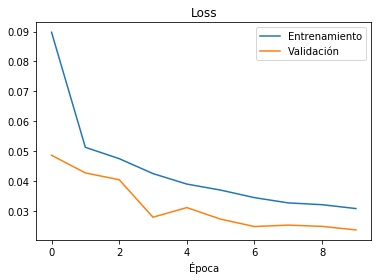


Exportando el modelo con el nombre nvidiaprueba9.h5...

Modelo exportado correctamente.


In [19]:
#prueba9(dataset_preprocesado, red, epochs, training_batch_size, steps_per_epoch, 
#                                                       validation_batch_size, validation_steps, nombre_fichero)
prueba9(dataset_preprocesado, "nvidia", 10, 150, 300, 100, 200, "nvidiaprueba9.h5")